In [253]:
from typing import *

from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt


In [254]:
class HyperParameters:
    def __init__(self, 
                 num_params:int, 
                 limits: list[tuple[float,float]]=None, 
                 parameters: np.ndarray[float]=None):
        if not isinstance(num_params, int):
            raise TypeError('num_params must be an integer.')
        if num_params <= 0:
            raise ValueError('num_params must be greater than 0.')
        if limits is not None:
            if len(limits) != num_params:
                raise ValueError('list of limits should be of length "num_params". ')
        if parameters is not None:
            if len(parameters) != num_params:
                raise ValueError('When explicitly provided, the number of parameters should be equal to "num_params". ')
        self.num_params = num_params
        self.limits = limits
        self.parameters = parameters
        
    def get_parameters(self):
        if self.parameters is None:
            raise RuntimeError(f' "parameters" attribute has not been set. ')
        return self.parameters
    
    def set_parameters(self, parameters: np.ndarray[float]):
        if len(parameters) != self.num_params:
                raise ValueError('When explicitly provided, the number of parameters should be equal to "num_params". ')
        self.parameters = parameters
        
    def set_random_parameters(self):
        self.parameters = self.get_random_parameters()
    
    def get_random_parameters(self, distribution: str = 'uniform'):
        if distribution == 'uniform':
            if self.limits is not None:
                self.parameters = np.array([uniform(low=limit[0], high=limit[1]) for limit in self.limits])
            else:
                self.parameters = np.array([uniform(low=-np.inf, high=np.inf) for _ in range(self.num_params)])
            return self.get_parameters()
        

class CovarianceMatrix:
    def __init__(self, kernel: Callable):
        self.kernel = kernel
        self.matrix = None
        self.samples = []
        
    def update_matrix(self, new_samples: list[HyperParameters]):
        # Updating samples
        self.samples.extend(new_samples)
        
        # Filling matrix for first time
        if self.matrix is None:
            N = len(self.samples)
            matrix = np.empty((N, N), dtype=float)
            for i in range(N):
                for j in range(i,N):
                    matrix[i,j] = self.kernel(self.samples[i],self.samples[j])
                    if i != j:
                        matrix[j, i] = matrix[i, j]
            self.matrix = matrix
            
        # Updating existing matrix 
        else:
            N_new, N_old = len(new_samples), self.matrix.shape[0]
            N_total = N_new + N_old
            total_matrix = np.empty((N_total, N_total), dtype=float)
            
            # Updating total matrix w. old covariances
            total_matrix[:N_old,:N_old] = self.matrix
            
            # Calculating covariances between old and new samples
            for i in range(N_old):
                for j in range(N_new):
                    total_matrix[i, N_old + j] = self.kernel(self.samples[i], new_samples[j])
                    total_matrix[N_old + j, i] = total_matrix[i, N_old + j]
            
            # Calculating covariances between new samples
            for i in range(N_new):
                for j in range(i, N_new):
                    total_matrix[N_old + i, N_old + j] = self.kernel(new_samples[i], new_samples[j])
                    if i != j:
                        total_matrix[N_old + j, N_old + i] = total_matrix[N_old + i, N_old + j]
                        
            self.matrix = total_matrix
                       
    def get_matrix(self):
        if self.matrix is None:
            raise RuntimeError(f' "matrix" attribute has not yet been set. Method: ".update_matrix()" must be called first. ')
        return self.matrix
    

class GaussianProcess:
    def __init__(self, kernel: Callable, optimization_function: Callable):
        
        self.optimization_function = optimization_function
        self.kernel = kernel
        self.covariance_matrix = CovarianceMatrix(kernel=self.kernel)
        
        # Define sample = x, then y=f(x) is sample_value 
        self.sample_values = []
    
    def add_samples(self, samples: list[HyperParameters]) -> None:
        self.covariance_matrix.update_matrix(new_samples=samples)
        for sample in samples:
            self.sample_values.append(self.optimization_function(sample))
    
    def get_mean_and_variance(self, sample: HyperParameters) -> tuple[float, float]:
        if self.covariance_matrix.matrix is None:
            raise RuntimeError(f'No samples have been given yet - expecting call to method ".add_samples()" first. ')
        kernel_vector = np.array([self.kernel(old_sample, sample) for old_sample in self.covariance_matrix.samples])
        inv_covar = np.linalg.inv(self.covariance_matrix.get_matrix())
        mean = np.dot(kernel_vector, np.dot(inv_covar, np.array(self.sample_values)))
        variance = self.kernel(sample,sample) - np.dot(kernel_vector, np.dot(inv_covar, np.array(kernel_vector)))
        return mean, variance


class BayesianOptimization:
    def __init__(self, 
                 kernel: Callable, 
                 optimization_function: Callable,
                 limits: list[tuple[float,float]]):
        
        self.limits = limits
        self.kernel = kernel
        self.optimization_function = optimization_function
        self.gaussian_process = GaussianProcess(kernel=self.kernel, optimization_function=self.optimization_function)
        self.best_sample, self.best_sample_value = None, None
    
    def acquisition_function(self, sample: HyperParameters) -> float:
        
        def probability_of_improvement(best_sample_value: float, mean: float, variance: float) -> float:
            return norm.cdf((best_sample_value-mean)/np.sqrt(variance))
        
        mean, variance = self.gaussian_process.get_mean_and_variance(sample=sample)
        return -probability_of_improvement(best_sample_value=self.best_sample_value, mean=mean, variance=variance)
    
    def optimize(self, N_warmup: int, N_optimize: int):
        # Warm-up
        samples = []
        for random_sample in range(N_warmup):
            params = HyperParameters(num_params=len(self.limits),limits=self.limits)
            params.set_random_parameters()
            samples.append(params)     
        self.gaussian_process.add_samples(samples=samples)
        best_idx = np.argmin(self.gaussian_process.sample_values)
        self.best_sample, self.best_sample_value = samples[best_idx], self.gaussian_process.sample_values[best_idx]
        
        # Optimization        
        def wrapper(x: np.ndarray[float]) -> float:
            return self.acquisition_function(sample=HyperParameters(num_params=len(self.limits),
                                                                    limits=self.limits,
                                                                     parameters=x))
        for optimization_sample in range(N_optimize):
            # argmin_x 
            init = HyperParameters(num_params=len(self.limits),limits=self.limits)
            init.set_random_parameters()
            res = minimize(fun=wrapper, x0=init.get_parameters().flatten(), method='COBYLA', bounds=self.limits)
            x_i = HyperParameters(num_params=len(self.limits), limits=self.limits, parameters=res.x)
            
            # Update samples, sample-values and covariance matrix.
            self.gaussian_process.add_samples(samples=[x_i])
            
            # Update best values 
            best_idx = np.argmin(self.gaussian_process.sample_values)
            self.best_sample, self.best_sample_value = self.gaussian_process.covariance_matrix.samples[best_idx], self.gaussian_process.sample_values[best_idx]
        
        return {'x': self.best_sample.get_parameters(),
                'y': self.best_sample_value}
            

    
def rbf_kernel(x1: HyperParameters, x2: HyperParameters, length_scale=1.0, sigma_f=1.0):
    """
    Compute the Radial Basis Function (RBF) kernel between two d-dimensional vectors.

    """
    # Compute the squared Euclidean distance between the vectors
    sqdist = np.sum((x1.get_parameters() - x2.get_parameters())**2)
    
    # Compute the RBF kernel
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)
        

# Treating variables as hyperparameters as an initial example         
def rosenbrock(x: HyperParameters) -> float:
    x1, x2 = x.get_parameters(), x.get_parameters()[1]
    return ((1 - x1) ** 2 + 100 * (x2-x1 ** 2) ** 2)[0]

limits = [(-2,2), (-2,3)]
opt = BayesianOptimization(kernel=rbf_kernel, 
                           optimization_function=rosenbrock,
                           limits=limits)

opt.optimize(N_warmup=5,N_optimize=50)

{'x': array([0.93235558, 0.85099487]), 'y': 0.03803572825175347}

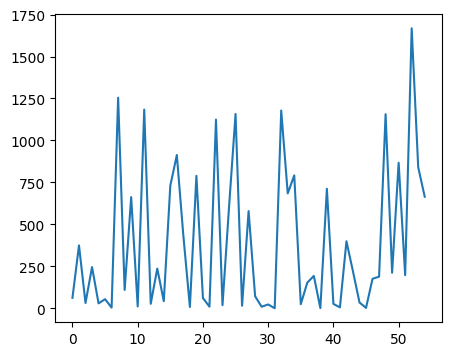

In [255]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot([_ for _ in range(len(opt.gaussian_process.sample_values))],opt.gaussian_process.sample_values)